In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from PIL import Image

import glob
import os
import re

%matplotlib inline

In [3]:
cwd = os.getcwd()

SAMPLE_SIZE = 10890
TRAIN_SPLIT_RATIO = 0.7
VALIDATION_SPLIT_RATIO = 0.2

PADDING_SIZE = 20
IMAGE_SIZE = 256
BATCH_SIZE = 4

BLOCK_POS_RANGE = 10

In [7]:
index = np.arange(SAMPLE_SIZE) + 1
np.random.seed(1234)
np.random.shuffle(index)

split = (int) (SAMPLE_SIZE * TRAIN_SPLIT_RATIO)
split_val = (int) (SAMPLE_SIZE * (TRAIN_SPLIT_RATIO + VALIDATION_SPLIT_RATIO))
x_train_idx = index[0:split]
x_val_idx = index[split:split_val]
x_test_idx = index[split_val:]

In [8]:
ALL_WORD = ['<none>', '', 'statement', 'if', 'else', 'elseif', 'while', 'end', '<START>', '<END>']
N_ONEHOT_WORD = len(ALL_WORD)
CHARS_MAP = {v: k for k, v in enumerate(ALL_WORD)}
IDX_MAP = dict(list(enumerate(ALL_WORD)))

def to_onehot(word):
    n_onehot = N_ONEHOT_WORD
    idx = CHARS_MAP[word]
    onehot_vec = np.zeros(n_onehot)
    onehot_vec[idx] = 1
    return onehot_vec

def convert_to_feature_list(feature_words):
    onehots = []
    for word in feature_words:
        onehots.append(CHARS_MAP[word])
    return np.array(onehots)
        

def convert_to_input_set(tokens, k):
    n_tokens = len(tokens)
    padded_token = [''] * k + tokens
    res = []
    for i in range(n_tokens):
        res.append((
            convert_to_feature_list(padded_token[i:i + k]),
            to_onehot(padded_token[i + k])
        ))
    return res

def read_image(image_file):
    image = Image.open(image_file).convert('L')
    width, height = image.size
    image = image.convert()
    image = image.resize((IMAGE_SIZE, IMAGE_SIZE))
    image = np.asarray(image).reshape((IMAGE_SIZE, IMAGE_SIZE, 1))
    return 1 - (image / 255), width, height

In [9]:
debug = False

def load_block_pos_data(block_pos_file, img_width, img_height):
    block_pos = pd.read_csv(block_pos_file, header=None)
    
    block_pos.loc[block_pos[0] == "else", [1,2]] = -1
    block_pos[[1,2]] = block_pos[[1,2]].astype(float)
    
#     if debug:
#         print(block_pos)
    
    block_pos.loc[block_pos[1] > 0, 1] *= BLOCK_POS_RANGE / img_width
    block_pos.loc[block_pos[2] > 0, 2] *= BLOCK_POS_RANGE / img_height
    
    embed_lang = convert_to_input_set(block_pos[0].values.tolist(), PADDING_SIZE)
    
    i = 0
    for lang, y in embed_lang:
        yield lang, block_pos.loc[i, [1,2]].values, y
        i += 1

def input_generator(indexs):
    files = glob.glob("./data/*")
    
    while(True):
        x_word = []
        x_image = []
        y_pos = []
        y = []
        
        for idx in indexs:
            picture_files = list(filter(re.compile(".\/data\/sample-" + str(idx) + "-\d+.jpg").search, files))
            block_pos_files = list(filter(re.compile(".\/data\/sample-" + str(idx) + "-\d+-block-pos.csv").search, files))
            
            if len(block_pos_files) == 0:
                continue
                
            for pic_file in picture_files:
                match = re.match( r'.+sample-(\d+)-(\d+).jpg', pic_file)

                if not match:
                    continue
                
                image, img_width, img_height = read_image(pic_file)
                
                pic_id = match.group(2)
                for block_pos_file in block_pos_files:
                    match = re.match( r'.+sample-(\d+)-(\d+)-block-pos.csv', block_pos_file)
                    
                    if not match:
                        continue
                        
                    bp_id = match.group(2)
                    if bp_id == pic_id:
                        for x_word_s, y_pos_s, y_s in load_block_pos_data(block_pos_file, img_width, img_height):
                            x_word.append(x_word_s)
                            x_image.append(image)
                            y_pos.append(y_pos_s)
                            y.append(y_s)
                            
                            if len(y) >= BATCH_SIZE:
                                yield [np.array(x_word), np.array(x_image)], [np.array(y_pos), np.array(y)]
                                x_word = []
                                x_image = []
                                y_pos = []
                                y = []

In [10]:
def test_input_generator():
    global debug
    debug = False
    count = 0
    for x,y in input_generator(x_train_idx):
        count += 1
        if count % 5 == 0:
            print(count)
            print(y[0])
#         print(x[0].shape, x[1].shape)
#         print(y[0].shape, y[1].shape)
#         print("======")
#         if count >= 222:
#             debug = True
        if count > 100:
            break

# test_input_generator()

In [11]:
from keras.layers import Input, Dense, Flatten, Concatenate, Conv2D, MaxPooling2D, LSTM, RepeatVector, Embedding
from keras.layers import Reshape, UpSampling2D
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K

def generate_model():
#     word_input = Input(batch_shape=(BATCH_SIZE, PADDING_SIZE, N_ONEHOT_WORD))
    word_input = Input(batch_shape=(BATCH_SIZE, PADDING_SIZE))
    image_input = Input(batch_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 1))
    
    img = Conv2D(32, (3, 3), padding='same', activation='relu', trainable=False)(image_input)
    
    img = MaxPooling2D()(img)
    img = Conv2D(64, (3,3), padding='same', activation='relu', trainable=False)(img)
    
    img = MaxPooling2D()(img)
    img = Conv2D(92, (3,3), padding='same', activation='relu', trainable=False)(img)
    
    img = MaxPooling2D()(img)
    img = Conv2D(128, (3,3), padding='same', activation='relu', trainable=False)(img)
    
    img = MaxPooling2D()(img)
    img = Conv2D(192, (3,3), padding='same', activation='relu', trainable=False)(img)
    
    img = MaxPooling2D()(img)
    img = Conv2D(224, (3,3), padding='same', activation='relu', trainable=False)(img)
    
    img = Flatten()(img)
    img = Dense(2048, trainable=False)(img)
    img = RepeatVector(PADDING_SIZE)(img)
    
    w = Embedding(N_ONEHOT_WORD, 64)(word_input)
    w = LSTM(512, return_sequences=True)(w)
    w = LSTM(512, return_sequences=True)(w)
    
    x = Concatenate()([w, img])
    x = LSTM(512, return_sequences=True)(x)
    x = LSTM(512)(x)
    
    y = Dense(512)(x)
    y = Dense(N_ONEHOT_WORD, activation='softmax', name='y_word')(y)
    
    y_pos = Dense(512)(x)
    y_pos = Dense(2, name='y_position')(y_pos)

    optimizer = Adam(lr=0.0001)
    model = Model(inputs=[word_input, image_input], outputs=[y_pos, y])
    
    model.compile(optimizer=optimizer,
                  loss=['mse', 'categorical_crossentropy'],
                  metrics={'y_position':'mse', 'y_word':'accuracy'})
    
    return model

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
# tmp = generate_model()
# del tmp

In [8]:
def generate_model_v8_3():
    image_input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))
    
    img = Conv2D(32, (3, 3), padding='same', activation='relu')(image_input)
    
    img = MaxPooling2D()(img)
    img = Conv2D(64, (3,3), padding='same', activation='relu')(img)
    
    img = MaxPooling2D()(img)
    img = Conv2D(92, (3,3), padding='same', activation='relu')(img)
    
    img = MaxPooling2D()(img)
    img = Conv2D(128, (3,3), padding='same', activation='relu')(img)
    
    img = MaxPooling2D()(img)
    img = Conv2D(192, (3,3), padding='same', activation='relu')(img)
    
    img = MaxPooling2D()(img)
    img = Conv2D(224, (3,3), padding='same', activation='relu')(img)
    
    img = Flatten()(img)
    img = Dense(2048)(img)
    
    img = Dense(8*8*224)(img)
    img = Reshape((8,8,224))(img)
    
    img = Conv2D(224, (3,3), padding='same', activation='relu')(img)
    img = UpSampling2D()(img)
    
    img = Conv2D(192, (3,3), padding='same', activation='relu')(img)
    img = UpSampling2D()(img)
    
    img = Conv2D(128, (3,3), padding='same', activation='relu')(img)
    img = UpSampling2D()(img)
    
    img = Conv2D(92, (3,3), padding='same', activation='relu')(img)
    img = UpSampling2D()(img)
    
    img = Conv2D(64, (3,3), padding='same', activation='relu')(img)
    img = UpSampling2D()(img)
    
    img = Conv2D(32, (3, 3), padding='same', activation='relu')(img)
    img = Conv2D(1, (3, 3), padding='same', activation='sigmoid')(img)

    outputs = img

    model = Model(inputs=image_input, outputs=outputs)
    model.compile(optimizer='adadelta',
                  loss='binary_crossentropy')
    
    return model

In [17]:
try:
    del model
except NameError:
    pass
else:
    model = None

def migrate_model():
    global model
    model_img = generate_model_v8_3()
    model_img.load_weights('./model/model-ae-weight-8-3.hdf5')
    model_img_weights = model_img.get_weights()

    model = generate_model()


    target_layer = list(range(1,11)) + [12,16]
    origin_layer = list(range(1,12)) + [13]

    for i, t in enumerate(target_layer):
        o = origin_layer[i]
        print(model.layers[t].name + " : " + model_img.layers[o].name)
    #     if (t == 15):
    #         w = model.layers[t].get_weights()
    #         print(w[0].shape, w[1].shape)
    #         w = model_img.layers[o].get_weights()
    #         print(w[0].shape, w[1].shape)
        model.layers[t].set_weights(
            model_img.layers[o].get_weights()
        )
    
    print("!")
    
    del model_img

migrate_model()

conv2d_33 : conv2d_20
max_pooling2d_16 : max_pooling2d_11
conv2d_34 : conv2d_21
max_pooling2d_17 : max_pooling2d_12
conv2d_35 : conv2d_22
max_pooling2d_18 : max_pooling2d_13
conv2d_36 : conv2d_23
max_pooling2d_19 : max_pooling2d_14
conv2d_37 : conv2d_24
max_pooling2d_20 : max_pooling2d_15
conv2d_38 : conv2d_25
dense_8 : dense_6
!


In [9]:
from keras.callbacks import Callback

class TensorBoard(Callback):

    def __init__(self, log_dir='./logs',
                 write_graph=False,
                 start_steps=0,
                 batch_freq=1):
        super(TensorBoard, self).__init__()
        
        global tf, projector
        import tensorflow as tf
        from tensorflow.contrib.tensorboard.plugins import projector
        
        self.log_dir = log_dir
        self.batch_freq = batch_freq
        self.write_graph = write_graph
        
        self.start_steps = start_steps
        self.steps_counter = 1

    def set_model(self, model):
        self.model = model
        self.sess = K.get_session()
        
        self.merged = tf.summary.merge_all()

        if self.write_graph:
            self.writer = tf.summary.FileWriter(self.log_dir,
                                                self.sess.graph)
        else:
            self.writer = tf.summary.FileWriter(self.log_dir)
            
    def save_scalar(self, logs):
        log = logs or {}
        
        for name, value in logs.items():
            if name in ['batch', 'size']:
                continue
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.writer.add_summary(
                summary,
                self.start_steps + self.steps_counter
            )
        self.writer.flush()
            
    def on_batch_end(self, batch, logs=None):
        if self.steps_counter % self.batch_freq == 0:
            self.save_scalar(logs)
        self.steps_counter += 1

    def on_epoch_end(self, epoch, logs=None):
        self.save_scalar(logs)        

    def on_train_end(self, _):
        self.writer.close()

class ModelCheckpoint(Callback):

    def __init__(self,
                 filepath,
                 start_steps=0,
                 batch_freq=1):
        super(ModelCheckpoint, self).__init__()
        
        self.filepath = filepath
        
        self.steps_counter = 0
        self.start_steps = start_steps
        self.batch_freq = batch_freq
        
        self.steps_counter
        
    def save_model(self):
        self.model.save_weights(self.filepath, overwrite=True)
        
    def on_batch_end(self, batch, logs=None):
        if self.steps_counter % self.batch_freq == 0:
            self.save_model()
        self.steps_counter += 1
        
    def on_epoch_end(self, epoch, logs=None):
        self.save_model()

In [ ]:
print(model.summary())

In [11]:
model = generate_model()
model.load_weights("./model/model-weight-4-4.hdf5")

In [18]:
model.fit_generator(
    input_generator(x_train_idx),
    steps_per_epoch=514829/BATCH_SIZE,
    validation_data=input_generator(x_val_idx),
    validation_steps=147427/BATCH_SIZE,
    max_queue_size=5,
    epochs=1,
    use_multiprocessing=True,
    callbacks=[
        TensorBoard(
            log_dir="./model/logs/",
            batch_freq=50,
            start_steps=514800
        ),
        ModelCheckpoint(
            filepath="./model/model-weight-4.hdf5",
            batch_freq=500
        )
    ]
)

Epoch 1/1
     1/128707 [..............................] - ETA: 130:07:50 - loss: 0.0310 - y_position_loss: 0.0309 - y_word_loss: 4.7477e-05 - y_position_mean_squared_error: 0.0309 - y_word_acc: 1.0000

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (1.733326). Check your callbacks.
  % delta_t_median)


     2/128707 [..............................] - ETA: 103:18:50 - loss: 0.0298 - y_position_loss: 0.0297 - y_word_loss: 6.4796e-05 - y_position_mean_squared_error: 0.0297 - y_word_acc: 1.0000

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.867103). Check your callbacks.
  % delta_t_median)


128708/128707 [==============================] - 30785s 239ms/step - loss: 0.2526 - y_position_loss: 0.2238 - y_word_loss: 0.0288 - y_position_mean_squared_error: 0.2238 - y_word_acc: 0.9901 - val_loss: 0.5234 - val_y_position_loss: 0.4533 - val_y_word_loss: 0.0701 - val_y_position_mean_squared_error: 0.4533 - val_y_word_acc: 0.9806


Analysis

In [12]:
model = generate_model()
model.load_weights("./model/model-weight-4.hdf5")

In [15]:
model.evaluate_generator(
    input_generator(x_test_idx), 
    steps=75191,
    max_queue_size=5, 
    use_multiprocessing=True
)

[0.5218877707605672,
 0.4481711177856905,
 0.07371665367070555,
 0.4481711177856905,
 0.9795986221755263]

Actual :  ['QGKAoEDyt', 'XTslCEgKLoz', 'while', 'lRrBMuVCEkG', 'while', 'ZpOqWGavEX', 'end', 'end']
Predict:  ['<START>', 'statement', 'statement', 'while', 'statement', 'while', 'statement', 'end', 'end', '<END>']
           0         1         2
0    <START>  0.213328  0.062628
1  statement  0.213239  0.235864
2  statement  0.213261  0.409100
3      while  0.207960  0.582335
4  statement  0.711758  0.582335
5      while  0.717136  0.755589
6  statement  0.711780  0.956705
7        end -0.002833 -0.001580
8        end -0.002833 -0.001580
9      <END>  0.213349  0.769788
[[ 2.1437316   0.63297963]
 [ 1.9779401   2.0073004 ]
 [ 1.929627    3.7690077 ]
 [ 1.8627236   5.5105457 ]
 [ 4.62428     6.8132877 ]
 [ 6.303111    7.826391  ]
 [ 6.748425    9.497767  ]
 [-1.1375914  -0.92544186]
 [-1.0349766  -1.0490911 ]
 [ 2.4106655   7.978077  ]]
[[ 54.879528    16.204279  ]
 [ 50.635265    51.38689   ]
 [ 49.39845     96.486595  ]
 [ 47.685726   141.06998   ]
 [118.38157    174.42017   ]
 [161.

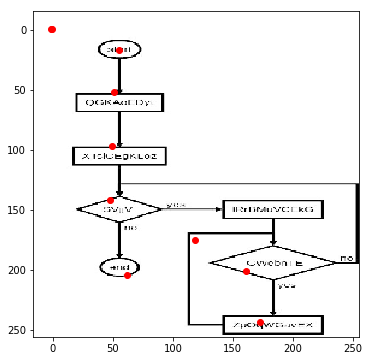

Actual :  ['if', 'sCSLjeJZG', 'while', 'BRCMYiXmd', 'end', 'end']
Predict:  ['<START>', 'if', 'statement', 'while', 'statement', 'end', 'end', '<END>']
           0         1         2
0    <START>  0.147432  0.139846
1         if  0.147426  0.491921
2  statement  0.481965  0.491856
3      while  0.816101  0.491880
4  statement  0.809358  0.917090
5        end -0.001669 -0.003030
6        end -0.001669 -0.003030
7      <END>  0.147445  0.880354
[[ 1.3548644   1.2518153 ]
 [ 1.4652457   4.852909  ]
 [ 4.8995275   4.775222  ]
 [ 7.760879    4.9320917 ]
 [ 7.996991    8.87273   ]
 [-1.0924579  -1.1173179 ]
 [-0.91753757 -1.1623976 ]
 [ 1.3656051   8.520273  ]]
[[ 34.68453     32.046474  ]
 [ 37.510292   124.234474  ]
 [125.42791    122.24568   ]
 [198.67851    126.26155   ]
 [204.72298    227.14189   ]
 [ -1.0924579   -1.1173179 ]
 [ -0.91753757  -1.1623976 ]
 [ 34.95949    218.119     ]]


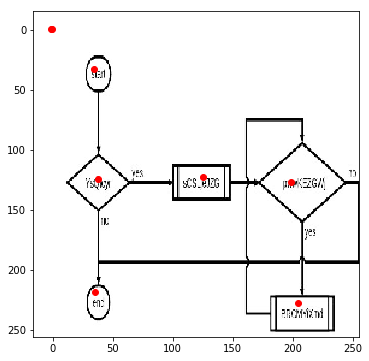

Actual :  ['while', 'vPoPnNHkRy', 'while', 'wMBqMbY', 'caSROmx', 'if', 'EgtZcHqXa', 'end', 'end', 'end']
Predict:  ['<START>', 'while', 'statement', 'while', 'statement', 'statement', 'if', 'statement', 'end', 'end', 'end', '<END>']
            0         1         2
0     <START>  0.147344  0.069478
1       while  0.149466  0.238706
2   statement  0.147294  0.430819
3       while  0.483182  0.430830
4   statement  0.844167  0.430819
5   statement  0.845779  0.600033
6          if  0.847711  0.769276
7   statement  0.845767  0.960849
8         end -0.001575 -0.001425
9         end -0.001575 -0.001425
10        end -0.001575 -0.001425
11      <END>  0.729428  0.238692
[[ 1.4585364   0.64049375]
 [ 1.4767083   2.3676581 ]
 [ 2.055766    4.527301  ]
 [ 2.4623919   1.5980175 ]
 [ 6.9074707   4.671894  ]
 [ 8.664003    6.1382227 ]
 [ 8.584812    8.0284    ]
 [ 8.121693    9.683438  ]
 [-1.115047   -0.92043984]
 [-1.19176    -0.9180769 ]
 [-1.4789572  -0.64994246]
 [ 6.530346    2.4287312 ]]


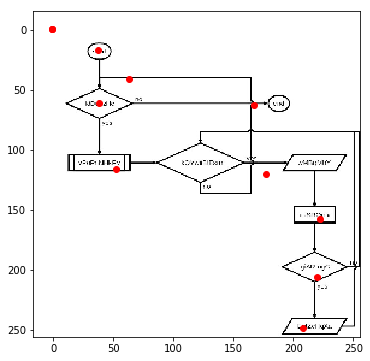

Actual :  ['while', 'qcKYY', 'while', 'amZiDOT', 'while', 'dFPkK', 'end', 'end', 'end']
Predict:  ['<START>', 'while', 'statement', 'while', 'statement', 'while', 'statement', 'end', 'end', 'end', '<END>']
            0         1         2
0     <START>  0.098258  0.155753
1       while  0.284897  0.155787
2   statement  0.282418  0.488879
3       while  0.476611  0.488923
4   statement  0.475711  0.811540
5       while  0.683286  0.811593
6   statement  0.930087  0.811540
7         end -0.001135 -0.002488
8         end -0.001135 -0.002488
9         end -0.001135 -0.002488
10      <END>  0.522874  0.155753
[[ 1.0534095   1.3384631 ]
 [ 2.599607    1.451742  ]
 [ 2.9947753   4.217584  ]
 [ 4.167325    4.801749  ]
 [ 4.474916    8.263375  ]
 [ 6.059154    7.613885  ]
 [ 8.702272    7.795165  ]
 [-1.0000272  -0.841817  ]
 [-0.90783393 -0.85137856]
 [-0.8883797  -0.72007513]
 [ 6.1449533   2.1983027 ]]
[[ 26.967283    34.264656  ]
 [ 66.54994     37.164597  ]
 [ 76.66625    107.97015   ]
 

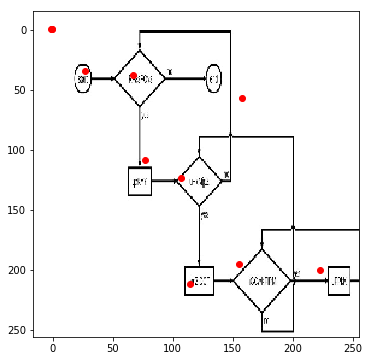

Actual :  ['CBGLpwnkwodA', 'while', 'eRZuiV', 'JIcVwlKXVY', 'cOVokyAKEt', 'end']
Predict:  ['<START>', 'statement', 'while', 'statement', 'statement', 'statement', 'end', '<END>']
           0         1         2
0    <START>  0.118352  0.083746
1  statement  0.118299  0.356716
2      while  0.115978  0.629686
3  statement  0.374434  0.629686
4  statement  0.636166  0.629686
5  statement  0.891877  0.629686
6        end -0.001357 -0.002703
7      <END>  0.118363  0.926980
[[ 1.0845629  0.7896446]
 [ 1.1444759  3.5200558]
 [ 1.3469     6.2636986]
 [ 5.027876   6.426736 ]
 [ 7.197402   6.3748026]
 [ 6.1865563  4.7228155]
 [-1.048762  -0.8413843]
 [ 1.4040067  8.983524 ]]
[[ 27.76481    20.214903 ]
 [ 29.298584   90.11343  ]
 [ 34.48064   160.3507   ]
 [128.71362   164.52444  ]
 [184.2535    163.19495  ]
 [158.37584   120.904076 ]
 [ -1.048762   -0.8413843]
 [ 35.942574  229.97823  ]]


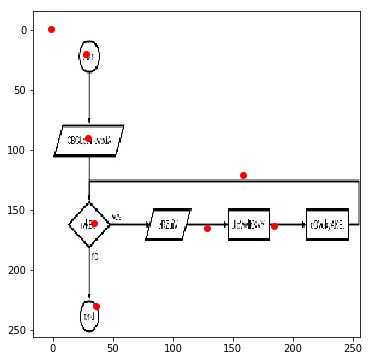

Actual :  ['while', 'pRktpnteOSt', 'if', 'VnwaEqZMsmWT', 'end', 'end']
Predict:  ['<START>', 'while', 'statement', 'if', 'statement', 'end', 'end', '<END>']
           0         1         2
0    <START>  0.309991  0.078836
1      while  0.311867  0.281191
2  statement  0.309896  0.508096
3         if  0.320647  0.710445
4  statement  0.309826  0.952795
5        end -0.003021 -0.001764
6        end -0.003021 -0.001764
7      <END>  0.918312  0.281154
[[ 3.0310411   0.676846  ]
 [ 3.040556    2.6745255 ]
 [ 2.9967322   5.129669  ]
 [ 3.0681086   7.246273  ]
 [ 2.947907    9.409707  ]
 [-1.053076   -1.0447708 ]
 [-0.94365036 -1.0152656 ]
 [ 9.160613    2.9190583 ]]
[[ 77.59466     17.32726   ]
 [ 77.838234    68.46786   ]
 [ 76.71635    131.31953   ]
 [ 78.54358    185.5046    ]
 [ 75.46642    240.8885    ]
 [ -1.053076    -1.0447708 ]
 [ -0.94365036  -1.0152656 ]
 [234.5117      74.7279    ]]


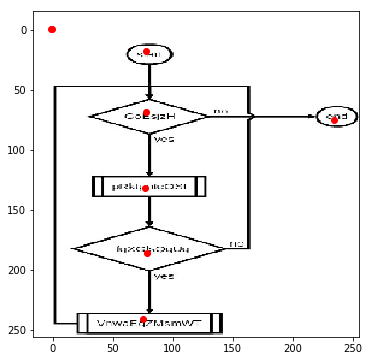

Actual :  ['if', 'EsUkABfVAfc', 'end', 'vkwSg', 'while', 'zCltjfgIUg', 'end']
Predict:  ['<START>', 'if', 'statement', 'end', 'statement', 'while', 'statement', 'end', '<END>']
           0         1         2
0    <START>  0.094912  0.095237
1         if  0.097812  0.352198
2  statement  0.693929  0.352171
3        end -0.001209 -0.002309
4  statement  0.094902  0.653571
5      while  0.301779  0.653602
6  statement  0.301812  0.938042
7        end -0.001209 -0.002309
8      <END>  0.532014  0.653571
[[ 0.84196204  0.99898005]
 [ 0.9037398   3.4218488 ]
 [ 6.315981    3.5777624 ]
 [-1.2442483  -0.8912896 ]
 [ 1.0024517   6.6528883 ]
 [ 3.3589015   6.457163  ]
 [ 2.7357845   9.147175  ]
 [-1.0851308  -0.98566365]
 [ 5.1231875   6.659481  ]]
[[ 21.554228    25.573889  ]
 [ 23.13574     87.59933   ]
 [161.68912     91.59072   ]
 [ -1.2442483   -0.8912896 ]
 [ 25.662764   170.31395   ]
 [ 85.98788    165.30338   ]
 [ 70.03609    234.16768   ]
 [ -1.0851308   -0.98566365]
 [131.15361    17

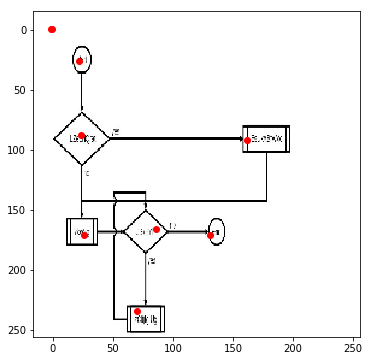

Actual :  ['if', 'cSCXAviJnH', 'end', 'KfdsJeY']
Predict:  ['<START>', 'if', 'statement', 'end', 'statement', '<END>']
           0         1         2
0    <START>  0.181178  0.144224
1         if  0.516594  0.144224
2  statement  0.506754  0.572613
3        end -0.001908 -0.002915
4  statement  0.882470  0.572613
5      <END>  0.882470  0.920918
[[ 1.7875803  1.5496534]
 [ 5.148299   1.4364862]
 [ 5.165345   5.680193 ]
 [-0.9368557 -1.0343732]
 [ 8.904995   5.9094296]
 [ 8.96518    9.21123  ]]
[[ 45.762054   39.671127 ]
 [131.79646    36.774048 ]
 [132.23283   145.41295  ]
 [ -0.9368557  -1.0343732]
 [227.96788   151.2814   ]
 [229.50862   235.8075   ]]


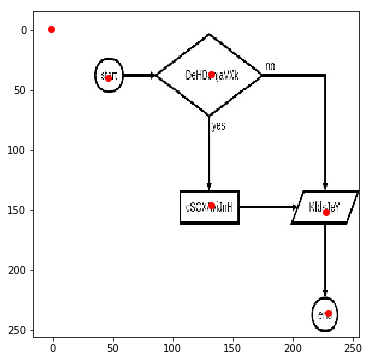

Actual :  ['xXJMw', 'hLnRaexyYeo', 'if', 'bENQbQJfRR', 'end']
Predict:  ['<START>', 'statement', 'statement', 'if', 'statement', 'end', '<END>']
           0         1         2
0    <START>  0.085626  0.204823
1  statement  0.256995  0.204823
2  statement  0.450276  0.204823
3         if  0.657604  0.204884
4  statement  0.881044  0.204823
5        end -0.001134 -0.005155
6      <END>  0.655461  0.862039
[[ 0.87329036  1.9530704 ]
 [ 2.4926968   1.9559233 ]
 [ 4.4703484   1.9893754 ]
 [ 6.5442853   1.9808354 ]
 [ 9.013496    1.80866   ]
 [-1.084479   -1.0079623 ]
 [ 6.6984344   8.675586  ]]
[[ 22.356234   49.998604 ]
 [ 63.813038   50.071636 ]
 [114.44092    50.92801  ]
 [167.5337     50.70939  ]
 [230.74551    46.301697 ]
 [ -1.084479   -1.0079623]
 [171.47992   222.095    ]]


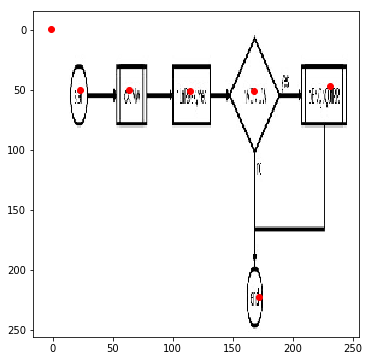

Actual :  ['if', 'JrUUe', 'while', 'gZpFIVrQu', 'end', 'end']
Predict:  ['<START>', 'if', 'statement', 'while', 'statement', 'end', 'end', '<END>']
           0         1         2
0    <START>  0.089054  0.265753
1         if  0.265881  0.265853
2  statement  0.495059  0.265753
3      while  0.687823  0.265844
4  statement  0.905242  0.265753
5        end -0.001122 -0.004630
6        end -0.001122 -0.004630
7      <END>  0.263054  0.873911
[[ 0.9598708   2.6766179 ]
 [ 2.7747455   2.6637373 ]
 [ 4.818853    2.8216615 ]
 [ 6.751686    2.727217  ]
 [ 8.911682    2.7033117 ]
 [-1.1387796  -0.98372066]
 [-1.1412866  -0.7906754 ]
 [ 2.7529635   8.78776   ]]
[[ 24.572693    68.521416  ]
 [ 71.033485    68.19167   ]
 [123.36263     72.234535  ]
 [172.84317     69.81676   ]
 [228.13907     69.20478   ]
 [ -1.1387796   -0.98372066]
 [ -1.1412866   -0.7906754 ]
 [ 70.47587    224.96666   ]]


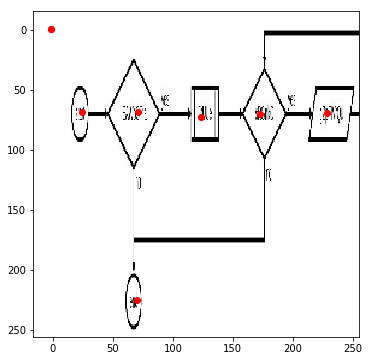

Actual :  ['afuAv', 'if', 'aQPtjniFlNcz', 'else', 'QbQcfO', 'end']
Predict:  ['<START>', 'statement', 'if', 'statement', 'end', 'statement', '<END>']
           0         1         2
0    <START>  0.092467  0.184434
1  statement  0.292882  0.184434
2         if  0.496774  0.184434
3  statement  0.499147  0.839189
4       else -0.001427 -0.005952
5  statement  0.905828  0.184434
6        end -0.001427 -0.005952
7      <END>  0.752644  0.839189
[[ 0.8373349  1.8296218]
 [ 2.7989836  1.8164768]
 [ 5.1092525  1.8328868]
 [ 7.8028917  3.9494364]
 [-0.9404563 -1.0046976]
 [ 4.9364552  8.303258 ]
 [ 7.662768   8.563622 ]]
[[ 21.435774   46.838318 ]
 [ 71.653984   46.50181  ]
 [130.79686    46.9219   ]
 [199.75403   101.105576 ]
 [ -0.9404563  -1.0046976]
 [126.37325   212.5634   ]
 [196.16685   219.22874  ]]


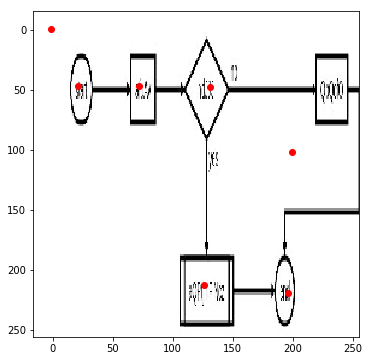

Actual :  ['SRQNOWE', 'while', 'qMsAZ', 'end', 'dgVWXy']
Predict:  ['<START>', 'statement', 'while', 'statement', 'end', 'statement', '<END>']
           0         1         2
0    <START>  0.105853  0.287320
1  statement  0.310810  0.287320
2      while  0.549964  0.287373
3  statement  0.918586  0.287320
4        end -0.001311 -0.004464
5  statement  0.546330  0.879957
6      <END>  0.782228  0.879957
[[ 1.0059953  2.6580698]
 [ 3.020949   2.801674 ]
 [ 5.456457   2.8265781]
 [ 8.971705   2.6696815]
 [-1.0913507 -0.9932052]
 [ 5.521222   8.859488 ]
 [ 7.6286354  8.885252 ]]
[[ 25.753479   68.04659  ]
 [ 77.336296   71.722855 ]
 [139.6853     72.360405 ]
 [229.67566    68.34385  ]
 [ -1.0913507  -0.9932052]
 [141.34329   226.80289  ]
 [195.29308   227.46245  ]]


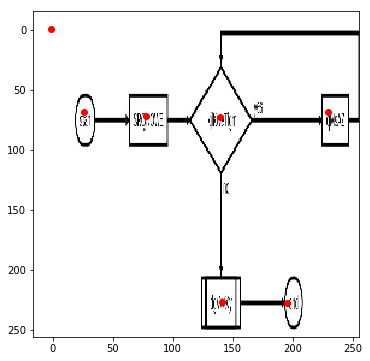

Actual :  ['while', 'LgzgZDzfu', 'end', 'oyTqDDBVIvJs']
Predict:  ['<START>', 'while', 'statement', 'end', 'statement', '<END>']
           0         1         2
0    <START>  0.183692  0.144384
1      while  0.193732  0.492267
2  statement  0.839385  0.492256
3        end -0.001927 -0.002907
4  statement  0.183692  0.920558
5      <END>  0.597543  0.920558
[[ 1.856838    1.4035803 ]
 [ 1.8914256   4.8250055 ]
 [ 8.1244755   4.7824087 ]
 [-1.0100516  -0.96136963]
 [ 1.6587381   9.220365  ]
 [ 5.8948092   9.220024  ]]
[[ 47.535053    35.931656  ]
 [ 48.420498   123.52014   ]
 [207.98657    122.429665  ]
 [ -1.0100516   -0.96136963]
 [ 42.463696   236.04134   ]
 [150.90712    236.03262   ]]


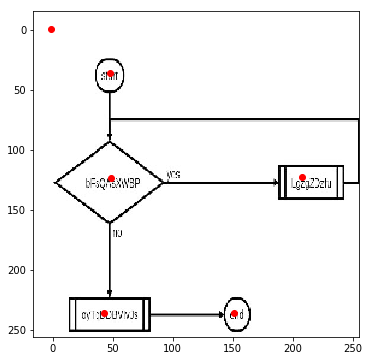

Actual :  ['while', 'XLOJNX', 'SLvDcAQ', 'GMbWred', 'UagTGHv', 'end']
Predict:  ['<START>', 'while', 'statement', 'statement', 'statement', 'statement', 'end', '<END>']
           0         1         2
0    <START>  0.160923  0.110795
1      while  0.502666  0.110836
2  statement  0.501157  0.340094
3  statement  0.501157  0.542695
4  statement  0.501120  0.745296
5  statement  0.501138  0.947898
6        end -0.002370 -0.001912
7      <END>  0.936851  0.110795
[[ 1.6657236   1.0224618 ]
 [ 4.8464875   0.9522201 ]
 [ 5.2678037   3.5012376 ]
 [ 4.81267     5.3972235 ]
 [ 4.7327037   7.489668  ]
 [ 4.9623723   9.526024  ]
 [-0.9876381  -0.84125185]
 [ 9.147176    1.4237189 ]]
[[ 42.642525    26.175022  ]
 [124.07008     24.376835  ]
 [134.85577     89.63168   ]
 [123.20436    138.16893   ]
 [121.15722    191.7355    ]
 [127.036736   243.86621   ]
 [ -0.9876381   -0.84125185]
 [234.16771     36.447205  ]]


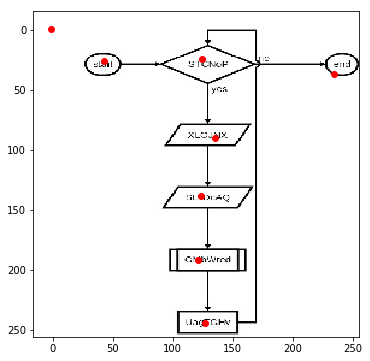

Actual :  ['if', 'koyUWYHhD', 'end', 'VDjuqUFcbaz']
Predict:  ['<START>', 'if', 'statement', 'end', 'statement', '<END>']
           0         1         2
0    <START>  0.223048  0.090190
1         if  0.224290  0.359035
2  statement  0.222935  0.661890
3        end -0.002890 -0.002551
4  statement  0.773226  0.661890
5      <END>  0.773339  0.930686
[[ 2.3308353   0.8914648 ]
 [ 2.3379436   3.4837475 ]
 [ 2.2464962   6.462743  ]
 [-0.9621433  -0.97668695]
 [ 7.652188    6.736228  ]
 [ 8.000167    9.460108  ]]
[[ 59.669384    22.8215    ]
 [ 59.851357    89.18394   ]
 [ 57.510303   165.44621   ]
 [ -0.9621433   -0.97668695]
 [195.89601    172.44743   ]
 [204.80428    242.17876   ]]


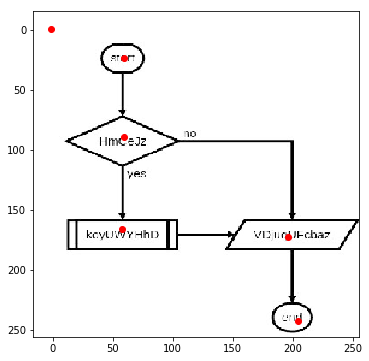

Actual :  ['while', 'BzCjO', 'end', 'eyFLEImwpVot', 'OzgXaLcW']
Predict:  ['<START>', 'while', 'statement', 'end', 'statement', 'statement', '<END>']
           0         1         2
0    <START>  0.174275  0.140566
1      while  0.182424  0.492624
2  statement  0.828370  0.492612
3        end -0.001957 -0.003021
4  statement  0.174275  0.918760
5  statement  0.581672  0.918760
6      <END>  0.947315  0.918760
[[ 1.7482647   1.3321083 ]
 [ 1.8281059   4.799011  ]
 [ 7.7281027   5.2615166 ]
 [-0.93122816 -0.7026824 ]
 [ 1.3313744   9.551562  ]
 [ 5.666059    8.969148  ]
 [ 9.535507    9.200127  ]]
[[ 44.755577    34.10197   ]
 [ 46.79951    122.85469   ]
 [197.83943    134.69482   ]
 [ -0.93122816  -0.7026824 ]
 [ 34.083187   244.52      ]
 [145.05112    229.61018   ]
 [244.109      235.52324   ]]


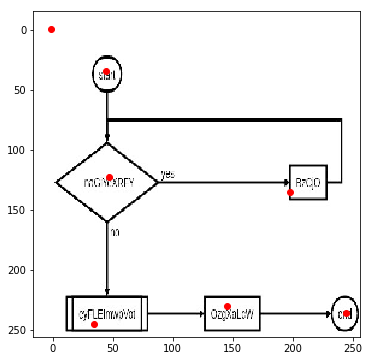

Actual :  ['while', 'RZpdHFWcJJRB', 'end', 'rATjddEhI']
Predict:  ['<START>', 'while', 'statement', 'end', 'statement', '<END>']
           0         1         2
0    <START>  0.291357  0.143195
1      while  0.303600  0.492890
2  statement  0.291357  0.920861
3        end -0.002532 -0.002950
4  statement  0.884197  0.492879
5      <END>  0.884197  0.842563
[[ 3.0220609   1.3404856 ]
 [ 3.1523685   4.6482754 ]
 [ 2.686337    8.904909  ]
 [-1.0892681  -0.88087785]
 [ 8.638083    4.820257  ]
 [ 8.9040985   8.387819  ]]
[[ 77.36476     34.316433  ]
 [ 80.70064    118.99585   ]
 [ 68.770226   227.96568   ]
 [ -1.0892681   -0.88087785]
 [221.13493    123.39858   ]
 [227.94493    214.72818   ]]


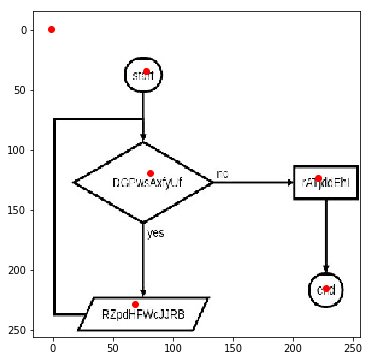

Actual :  ['iHMvBCzKY', 'Yjkae', 'while', 'RPKxEtdpLWL', 'end']
Predict:  ['<START>', 'statement', 'statement', 'while', 'statement', 'end', '<END>']
           0         1         2
0    <START>  0.123717  0.137338
1  statement  0.357864  0.137338
2  statement  0.643401  0.137338
3      while  0.648414  0.491480
4  statement  0.643356  0.914814
5        end -0.001460 -0.003096
6      <END>  0.960935  0.491438
[[ 1.2024183  1.2940545]
 [ 3.3617663  1.3671043]
 [ 6.203532   1.4568279]
 [ 6.44796    4.824934 ]
 [ 6.2176642  8.867097 ]
 [-1.0025868 -1.0549681]
 [ 9.784586   5.0901747]]
[[ 30.78191    33.127796 ]
 [ 86.06122    34.99787  ]
 [158.81042    37.294796 ]
 [165.06778   123.51831  ]
 [159.17221   226.99768  ]
 [ -1.0025868  -1.0549681]
 [250.4854    130.30847  ]]


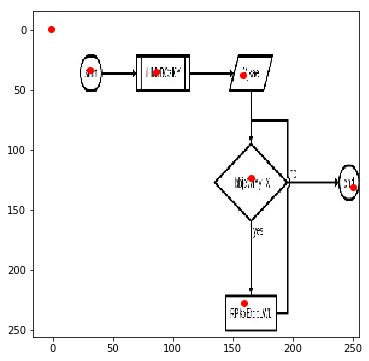

Actual :  ['while', 'CMavBpw', 'end', 'xFoTM', 'while', 'yWDAhnJxzP', 'end']
Predict:  ['<START>', 'while', 'statement', 'end', 'statement', 'while', 'statement', 'end', '<END>']
           0         1         2
0    <START>  0.129522  0.154923
1      while  0.370461  0.154923
2  statement  0.890720  0.154923
3        end -0.001504 -0.002924
4  statement  0.372834  0.517709
5      while  0.633862  0.517766
6  statement  0.628317  0.921647
7        end -0.001504 -0.002924
8      <END>  0.959646  0.517709
[[ 1.1144062   1.5023373 ]
 [ 3.517768    1.3725781 ]
 [ 8.804964    1.4322094 ]
 [-0.8281641  -0.8881842 ]
 [ 3.6356907   5.075452  ]
 [ 6.3742423   5.31528   ]
 [ 6.188363    9.074343  ]
 [-0.92735016 -1.0486149 ]
 [ 9.582944    5.182337  ]]
[[ 28.5288      38.459835  ]
 [ 90.05486     35.138     ]
 [225.40709     36.664562  ]
 [ -0.8281641   -0.8881842 ]
 [ 93.073685   129.93156   ]
 [163.1806     136.07117   ]
 [158.4221     232.30318   ]
 [ -0.92735016  -1.0486149 ]
 [245.32336    

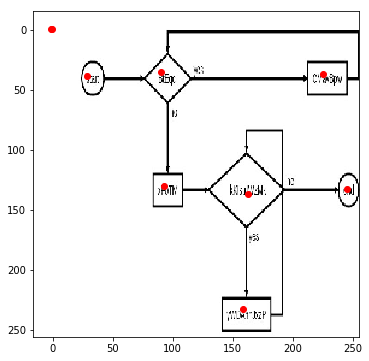

Actual :  ['if', 'tSFbOu', 'else', 'YGepTqzwkVV', 'end']
Predict:  ['<START>', 'if', 'statement', 'else', 'statement', 'end', '<END>']
           0         1         2
0    <START>  0.150772  0.228778
1         if  0.419195  0.228835
2  statement  0.909901  0.228778
3       else -0.001425 -0.004167
4  statement  0.409274  0.886461
5        end -0.001425 -0.004167
6      <END>  0.744986  0.886461
[[ 1.5311759   2.1068678 ]
 [ 4.29813     2.104619  ]
 [ 5.571988    6.322667  ]
 [-1.0695684  -1.0132368 ]
 [ 6.7566986   5.2786303 ]
 [-1.002304   -0.73898923]
 [ 6.951693    8.846413  ]]
[[ 39.1981      53.935818  ]
 [110.03213     53.878246  ]
 [142.6429     161.86028   ]
 [ -1.0695684   -1.0132368 ]
 [172.97148    135.13293   ]
 [ -1.002304    -0.73898923]
 [177.96335    226.46817   ]]


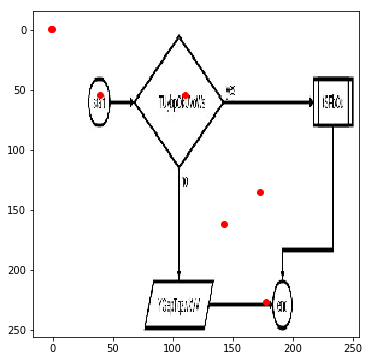

In [9]:
def analyze():
    files = glob.glob("./data/*")
    count = 0
    
    for idx in x_test_idx:
        count += 1
        if count % 5 == 0:
            picture_files = list(filter(re.compile(".\/data\/sample-" + str(idx) + "-\d+.jpg").search, files))
            lang_file = list(filter(re.compile(".\/data\/sample-" + str(idx) + "-lang.txt").search, files))

            image, img_width, img_height = read_image(picture_files[0])
            match = re.match( r'.+sample-(\d+)-(\d+).jpg', picture_files[0])   
            pic_id = match.group(2)

            with open(lang_file[0], 'r') as file:
                lang = [l.strip().split(" ")[0] for l in file.read().split("\n") if len(l)]
                lang = list(map(lambda x: "statement" if x.startswith("statement") else x, lang))

            plt.figure(figsize=(6,6))
            plt.imshow(image.reshape((IMAGE_SIZE, IMAGE_SIZE)), cmap="Greys")
            
            print("Actual : ", lang)
            
            tokens = np.zeros((BATCH_SIZE, PADDING_SIZE))
            images = np.zeros((BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 1))
            results = []
            
            token = [''] * (PADDING_SIZE + 1)
            
            for i in range(BATCH_SIZE):
                images[i] = image
            
            position = []
            
            for i in range(20):
                token = token[1:]
                
                tokens[BATCH_SIZE - 1] = convert_to_feature_list(token)
                
                pos, predict = model.predict([tokens, images])
                predict_token = ALL_WORD[np.argmax(predict[BATCH_SIZE - 1])]
                results.append(predict_token)
                
                token += [predict_token]
                position += [pos[BATCH_SIZE - 1]]
                
                if predict_token == "<END>":
                    break
            
            print("Predict: ", results)
            
            pos_true = pd.read_csv("./data/sample-{}-{}-block-pos.csv".format(idx, pic_id), header=None)
            pos_true.loc[pos_true[0] == "else", [1,2]] = -1
            pos_true[[1,2]] = pos_true[[1,2]].astype(float)
            pos_true[1] /= img_width
            pos_true[2] /= img_height
            
            print(pos_true)
            
            position = np.array(position)
            print(position)
            position[position[:,0] > 0,0] *= IMAGE_SIZE / 10
            position[position[:,1] > 0,1] *= IMAGE_SIZE / 10
            print(position)
            plt.scatter(position[:,0], position[:,1], c='r')
            plt.show()
        
        if count > 100:
            break

analyze()